# D4P 

## UPDRS Motor Scores

### Collect and store the data from the CSV files in a multi-dimensional list

In [1]:
import csv

disease_tables = ["BH_Disease_Table.csv",
                  "DL_Disease_Table.csv",
                  "EV_Disease_Table.csv",
                  "JF_Disease_Table.csv",
                  "LV_Disease_Table.csv"]

dtablelists = [[[], [], []],     # BH_Disease_Table at all 3 time points
               [[], []],         # DL_Disease_Table with only 2 time points
               [[], [], []],     # EV_Disease_Table at all 3 time points
               [[], [], []],     # JF_Disease_Table at all 3 time points
               [[], [], []]]     # LV_Disease_Table at all 3 time points

labels = []

i = 0 
for i in range (len(disease_tables)):
    with open (disease_tables[i]) as csvfile:             # Open each CSV file
        readCSV = csv.reader(csvfile, delimiter=",")      # Collect & store comma-separated values  
        j = i                                               
        for row in readCSV:
            if j == 1:                                    # Subject DL only has two timepoints
                dtablelists[j][0].append(row[1])
                dtablelists[j][1].append(row[2])
                labels.append(row[0])                     # Capture the names of each test
            else:                                         # All other subjects have all three timepoints
                dtablelists[j][0].append(row[1])
                dtablelists[j][1].append(row[2])
                dtablelists[j][2].append(row[3])
        i += 1

### Convert List of Strings (sequences of characters) to List of integers for statistical analysis

In [2]:
i = 0
j = 0
for i in range(len(dtablelists)):
    for j in range(len(dtablelists[i])):
        dtablelists[i][j].pop(0)                                   # Remove the first (date) element from the list
        dtablelists[i][j] = [int(x) for x in dtablelists[i][j]]    # Convert strings to ints
        j += 1
    i += 1

labels = labels[1:] # remove date (first row of column one) label

### Wilcoxon Signed-Rank Test

#### Compare UPDRS scores within-group at 2 timepoints (either baseline or intervention). Do this for each score (e.g. Speech, Facial Expression etc.) and record the significance of each. Use a non-parametric test (Wilcoxon Signed-Rank) because this is ordinal data (does not follow a normal distribution).

In [3]:
from scipy.stats import wilcoxon

# Computes the Wilcoxon Signed-Rank Test at two timepoints: Initial and Final
def d4p_wilcoxon(timepoint_i, timepoint_f):
    p_values = []     # List of the p-values for each score (e.g. Speech, Facial Expression, etc.)
    questionNum = 0   # Number characterizing the score (e.g. Speech = 0; Facial Expression = 1; etc.)
    for questionNum in range(len(labels)-1):  # Do not include get up & go (continuous, not ordinal)
        list_i = []    # List of scores for each question at the initial timepoint (i.e. 0 or 1)
        list_f = []    # List of scores for each question at the final timepoint (i.e. 1 or 2)
        i = 0
        for i in range(len(dtablelists)):
            if (len(dtablelists[i]) < 3):                        # Subject DL only has 2 timepoints. 
                list_i.append(dtablelists[i][0][questionNum])    # Regardless of whether we compare timepoint 0-1 
                list_f.append(dtablelists[i][1][questionNum])    # or 1-2, always use the same 2 timepoints for DL
            else:
                list_i.append(dtablelists[i][timepoint_i][questionNum])
                list_f.append(dtablelists[i][timepoint_f][questionNum])
        z_statistic, p_value = wilcoxon(list_i, list_f)
        p_values.append(p_value)
    return p_values


## Paired T-test

#### Comparing get up & go time using a parametric test

In [4]:
from scipy.stats import ttest_rel

# Computes the Paired T-Test at two timepoints: Initial and Final
def d4p_pairedttest(timepoint_i, timepoint_f):
    list_i = []     # List of the Get-Up-And-Go Scores at the initial timepoint (i.e. 0 or 1)
    list_f = []     # List of the Get-Up-And-Go Scores at the final timepoint (i.e. 1 or 2)
    i = 0
    for i in range(len(dtablelists)):
        if (len(dtablelists[i]) < 3):                  # Subject DL only has 2 timepoints
            list_i.append(dtablelists[i][0][-1])       # Regardless of whether we compare timepoint 0-1
            list_f.append(dtablelists[i][1][-1])       # or 1-2, always use same 2 timepoints for DL
        else:
            list_i.append(dtablelists[i][timepoint_i][-1]) # [-1] => Take the last scored item (Get-Up-And-Go)
            list_f.append(dtablelists[i][timepoint_f][-1])
    t_statistic, p_value = ttest_rel(list_i, list_f)
    return [p_value]


### Checking for significance

In [5]:
def anySignificance(siglevel, function, *timepoint_1, **timepoint_2):
    p_values = function(*timepoint_1, **timepoint_2)
    i = 0; boole = False; sigstr = {}
    if len(p_values) == 1:
        if p_values[0] < siglevel:
            sigstr[labels[-1]] = p_values[0]
            boole = True
        else:
            for i in range(len(p_values)):
                if p_values[i] < siglevel:
                    sigstr[labels[i]] = p_values[i]
                    boole = True
    if boole:
        print("Null hypothesis rejected at the " + str(siglevel) + " significance level")
        for k, v in sigstr.items(): print k, "=>", v, "(p-value)"
        return True
    print("Null hypothesis accepted at the " + str(siglevel) + " significance level")
    return False



### Checking to see if there are any significant changes for any of the scores b/w 2 timepoints ###
print ("UPDRS Baseline: "); anySignificance(0.10, d4p_wilcoxon, 0, 1); print("\n")
print ("UPDRS Intervention: "); anySignificance(0.10, d4p_wilcoxon, 1, 2); print("\n")

### Checking to see if there is any significant change for the Get-Up-And-Go time b/w 2 timepoints ###
print ("Get Up & Go - Baseline: "); anySignificance(0.10, d4p_pairedttest, 0, 1); print("\n")
print ("Get Up & Go - Intervention: "); anySignificance(0.10, d4p_pairedttest, 1, 2); print("\n")



UPDRS Baseline: 
Null hypothesis accepted at the 0.1 significance level


UPDRS Intervention: 
Null hypothesis accepted at the 0.1 significance level


Get Up & Go - Baseline: 
Null hypothesis accepted at the 0.1 significance level


Get Up & Go - Intervention: 
Null hypothesis rejected at the 0.1 significance level
Get Up & Go (seconds) => 0.0993006832137 (p-value)




/home/mbalas/.local/lib/python2.7/site-packages/scipy/stats/morestats.py:2397: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/home/mbalas/.local/lib/python2.7/site-packages/scipy/stats/morestats.py:2422: RuntimeWarning: invalid value encountered in double_scalars
  z = (T - mn - correction) / se


### The Only Significance Found at the 0.10 Level was the Get Up & Go Score (in seconds) => P-Value: 0.0993
#### However, this result itself is likely insignificant (even at the .10 level) since using parametric testing with such a low sample size likely led to spurious results. 

### Plot of the Graph for the Get Up and Go Scores for Each Subject at Each Timepoint

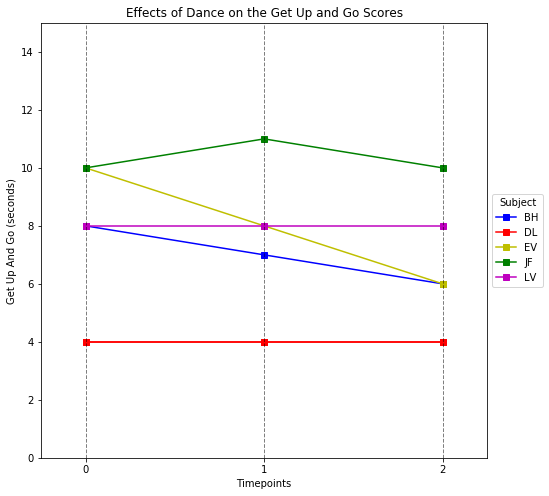

In [6]:
import matplotlib.pyplot as plt
from collections import OrderedDict


t = [0, 1, 2]
line = ['bs-', 'rs-', 'ys-', 'gs-', 'ms-']
subject = ["BH", "DL", "EV", "JF", "LV"]

plt.figure(figsize=(8,8))


for i in range(len(dtablelists)):
    if (len(dtablelists[i]) < 3):
        temp = []
        temp.append(dtablelists[i][0][-1])
        temp.append(dtablelists[i][0][-1])
        temp.append(dtablelists[i][1][-1])
        plt.plot(t, [4,4,4], line[i], label=subject[i])
    else:
        temp = []
        for j in range(3):
            temp.append(dtablelists[i][j][-1])
    plt.plot(t, temp, line[i], label=subject[i])
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5), title="Subject")

plt.axis([-0.25, 2.25, 0, 15])
plt.xticks(t)

plt.xlabel('Timepoints')
plt.ylabel('Get Up And Go (seconds)')
plt.title('Effects of Dance on the Get Up and Go Scores')

for x in t:
    plt.axvline(x, linewidth=1, color='black', ls='--', alpha = 0.5)

plt.show()